<div align="center">
    
<h1>Recommendations with IBM </h1> 

<a style="font-size: x-large;margin-left: 10%;" href="https://github.com/AlaGrine/udacity-recommendations-with-IBM" target="_blank"> https://github.com/AlaGrine/udacity-recommendations-with-IBM </a>


</div>

## Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Flask application](#FlaskApp)<br>
VII. [Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import plotly.express as px
import plotly.graph_objects as go

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import datetime

# %matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alaed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alaed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alaed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Import data using Pandas.read_csv

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

In [4]:
# Show df_content to get an idea of the data
df_content.head()

doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLoading...\r\n\r...   

                                     doc_description  \
0  Detect bad readings in real time using Python ...   
1  See the forest, see the trees. Here lies the c...   
2  Here’s this week’s news in Data Science and Bi...   
3  Learn how distributed DBs solve the problem of...   
4  This video demonstrates the power of IBM DataS...   

                                       doc_full_name doc_status  article_id  
0  Detect Malfunctioning IoT Sensors with Streami...       Live           0  
1  Communicating data science: A guide to present...       Live           1  
2         This Week in Data Science (April 18, 2017)       Live           2  
3  DataLayer Conference: Boost the performance of...       Live           3  
4      Analyze NY Restaurant data using Spark in DSX       Live           4

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
nb_articles_by_user = df.groupby('email')['article_id'].count().reset_index(name='count').\
                    sort_values(by='count',ascending=False)
nb_articles_by_user.head()

email  count
910   2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
2426  77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
985   2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
3312  a37adec71b667b297ed2440a9ff7dad427c7ac85    169
2680  8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160

In [6]:
# Plot User-Article Interactions
import plotly.express as px

import plotly.graph_objects as go
fig = px.histogram(nb_articles_by_user, x="count",  nbins=100)
fig.update_layout(title_text="<b>User-Article Interactions</b>",
                  title_x=0.5, # title position
                  xaxis_title="Number of user interactions",
                  yaxis_title="Count"                    
                 )
fig.show()

In [7]:
# Fill in the median and maximum number of user_article interactios below

# 1. 50% of individuals interact with ____ number of articles or fewer.
median_val = int(nb_articles_by_user['count'].median())
print(f"50% of individuals interact with {median_val} number of articles or fewer")

# 2. The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = int(nb_articles_by_user['count'].max())
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
id_duplicated = list(df_content.article_id.value_counts()[df_content.article_id.value_counts()>1].index)
nb_duplicated = len(id_duplicated)
print(f"There are {nb_duplicated} duplicate articles. Their ids are: {list(id_duplicated)}")

There are 5 duplicate articles. Their ids are: [221, 232, 50, 398, 577]


In [9]:
# Show an example of a duplicate article 

df_example = None

if len(id_duplicated)>0:
    id_ = np.random.randint(len(id_duplicated))
    print(f"Here is an example of a duplicate article whose ID is {id_duplicated[id_]}:")
    df_example = df_content[df_content.article_id==id_duplicated[id_]]
else:
    print(f"No duplicate articles have been found!")    

df_example

Here is an example of a duplicate article whose ID is 50:


doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
365  Follow Sign in / Sign up Home About Insight Da...   

                                       doc_description  \
50                        Community Detection at Scale   
365  During the seven-week Insight Data Engineering...   

                    doc_full_name doc_status  article_id  
50   Graph-based machine learning       Live          50  
365  Graph-based machine learning       Live          50

In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
print(f"a. The number of unique articles that have an interaction with a user is: {df['article_id'].nunique()}")
print(f"b. The number of unique articles in the dataset is: {df_content['article_id'].nunique()}")
print(f"c. The number of unique users in the dataset (excluding null values) is: {df['email'].nunique()}")
print(f"d. The number of user-article interactions in the dataset is: {df.shape[0]}")

a. The number of unique articles that have an interaction with a user is: 714
b. The number of unique articles in the dataset is: 1051
c. The number of unique users in the dataset (excluding null values) is: 5148
d. The number of user-article interactions in the dataset is: 45993


In [12]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
most_viewed_article = df.article_id.value_counts().head(1)

print (f"The most viewed article in the dataset is: '{most_viewed_article.index[0]}'")
print (f"The most viewed article in the dataset was viewed: {most_viewed_article.values[0]} times")

The most viewed article in the dataset is: '1429.0'
The most viewed article in the dataset was viewed: 937 times


In [14]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

article_id                                              title  user_id
0      1430.0  using pixiedust for fast, flexible, and easier...        1
1      1314.0       healthcare python streaming application demo        2
2      1429.0         use deep learning for image classification        3
3      1338.0          ml optimization using cognitive assistant        4
4      1276.0          deploy your python model as a restful api        5

In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
        top_articles - (list) A list of the top 'n' article titles 
    
    '''
    count_articles = df.groupby(['article_id','title']).count().\
                   sort_values(by="user_id",ascending=False).reset_index()                 
    
    top_articles = count_articles['title'].head(n).to_list()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
        top_articles - (list) A list of the top 'n' article titles 
    
    '''    
    top_articles_ids = list(df['article_id'].value_counts().head(n).index.astype('str'))
 
    return top_articles_ids 

In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
        df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
        user_item - user item matrix 
    
    Description:
        Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
        an article and a 0 otherwise
    '''    
    # 1. unstack the user-item dataframe
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id'])['title'].count().unstack()
    
    # 2. fill missing values with 0
    user_item = user_item.fillna(0)
    
    # 3. convert to int
    user_item = user_item.astype('int')
    
    return user_item 

# Create the user_item matrix
user_item = create_user_item_matrix(df)
user_item.head()

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1                0       0       0       0       0       0       0       0   
2                0       0       0       0       0       0       0       0   
3                0       0       0       0       0       1       0       0   
4                0       0       0       0       0       0       0       0   
5                0       0       0       0       0       0       0       0   

article_id  16.0    18.0    ...  1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                     ...                                           
1                0       0  ...       0       0       1       0       1   
2                0       0  ...       0       0       0       0       0   
3                0       0  ...       0       0       1       0       0   
4                0       0  ...       0       0       0       0       0   
5                0       0  ...       0       0       0       0       0   

article_id  1440.0  1441.0  1442.0  1443.0  1444.0  
user_id                                             
1                0       0       0       0       0  
2                0       0       0       0       0  
3                0       0       0       0       0  
4                0       0       0       0       0  
5                0       0       0       0       0  

[5 rows x 714 columns]

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
        user_id - (int) a user_id
        user_item - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
        similar_users - (list) an ordered list where the closest users (largest dot product users)
                        are listed first
    
    Description:
        Computes the similarity of every pair of users based on the dot product
        Returns an ordered
    
    '''
    # 1. compute similarity of every pair of users based on the dot product
    similarity = user_item.dot(user_item.loc[user_id])

    # 2. sort by similarity
    similarity = similarity.sort_values(ascending=False)

    # 3. create list of just the ids
    most_similar_users = similarity.index.tolist()
    
    # 4. remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
        article_ids - (list) a list of article ids
        df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
        article_names - (list) a list of article names associated with the list of article ids 
                        (this is identified by the title column)
    '''
    
    article_ids = list(map(float, article_ids)) # convert article_ids to float
    
    article_names = []
    for article_id in article_ids:
        article_names.append(df[df.article_id==article_id]['title'].unique()[0])
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
        user_id - (int) a user id
        user_item - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
        article_ids - (list) a list of the article ids seen by the user
        article_names - (list) a list of article names associated with the list of article ids 
                        (this is identified by the doc_full_name column in df_content)
    
    Description:
        Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # 1. Get past articles read by user_id
    user_articles = user_item.loc[user_id,:]
    
    # 2. Get only articles that user_id has interacted with
    article_ids = user_articles[user_articles == 1].index.values.astype('str').tolist()
    
    # 3. Get article names 
    article_names = get_article_names(article_ids)    
    
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user
    
    OUTPUT:
        recs - (list) a list of recommendations for the user
    
    Description:
        Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and provides them as recs
        Does this until m recommendations are found
    
    Notes:
        Users who are the same closeness are chosen arbitrarily as the 'next' user
    
        For the user where the number of recommended articles starts below m 
        and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # 1. Get most similar users 
    closest_neighbors = find_similar_users(user_id)
    
    # 2. Get past article ids read by user_id
    user_article_ids = get_user_articles(user_id)[0] 
    
    # 3. Create recommendations for this user
    recs = np.array([])
    
    for neighbor in closest_neighbors:
        # Get neighbor article ids
        neighbor_article_ids = get_user_articles(neighbor)[0]
        
        # Find new_recs: the list of articles that are not seen by user_id
        new_recs = np.setdiff1d(neighbor_article_ids,user_article_ids, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # Exit the loop if we have enough recommendations (at least m recs) 
        if len(recs) > m:
            break 
            
    recs = recs[:m].tolist()
    
    return recs # return your recommendations for this user_id    

In [29]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [31]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
        user_id - (int)
        df - (pandas dataframe) df as defined at the top of the notebook 
        user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise    
            
    OUTPUT:
        neighbors_df - (pandas dataframe) a dataframe with:
                        neighbor_id - is a neighbor user_id
                        similarity - measure of the similarity of each user to the provided user_id
                        num_interactions - the number of articles viewed by the user - if a u
                        
    Other Details:
        sort the neighbors_df by the similarity and then by number of interactions where 
        highest of each is higher in the dataframe
     
    ''' 
    
    # 1. Compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)
    
    # 2. Similarity dataframe
    df_similarity = pd.DataFrame(similarity.drop(user_id),columns=['similarity']).reset_index()
    df_similarity.columns = ['neighbor_id','similarity']
    
    # 3. Nbre of interactions DataFrame
    df_interactions = pd.DataFrame(df.user_id.value_counts().reset_index())
    df_interactions.columns=['neighbor_id','num_interactions']
    
    # 4. Merge similarity and interactions dataframe
    neighbors_df = pd.merge(df_similarity,df_interactions,on="neighbor_id")    
    
    # 5. Sort by similarity and interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user
    
    OUTPUT:
        recs - (list) a list of recommendations for the user by article id
        rec_names - (list) a list of recommendations for the user by article title
    
    Description:
        Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and provides them as recs
        Does this until m recommendations are found
    
    Notes:
        * Choose the users that have the most total article interactions 
        before choosing those with fewer article interactions.

        * Choose articles with the articles with the most total interactions 
        before choosing those with fewer total interactions. 
   
    '''
    
    # 1. Get most similar users 
    closest_neighbors_df = get_top_sorted_users(user_id)
    closest_neighbors = closest_neighbors_df.neighbor_id.tolist()
    
    # 2. Get article ids seen by user_id
    user_article_ids = get_user_articles(user_id)[0]
    
    # 3. Create recommendations for user_id
    recs = np.array([])
    
    for neighbor in closest_neighbors:
        # Get neighbor article ids
        neighbor_article_ids = get_user_articles(neighbor, user_item)[0]
        
        # Find new_recs: the list of articles that are not read by the user
        new_recs = np.setdiff1d(neighbor_article_ids, user_article_ids, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # Exit the loop if we have enough recommendations (at least m recs) 
        if len(recs) >= m:
            break
    
    recs = recs[:m].tolist()
    rec_names = get_article_names(recs, df=df) 
    
    return recs, rec_names

In [32]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("Ids:",rec_ids,"\n")
print("Names:",rec_names)

Ids: ['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0'] 

Names: ['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [33]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9] # Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

> 📖 **Answer:**<br>
> * When we get a new user, we cannot use either the **user-user based** collaborative filtering or the **content based** methods because we have no information about the new user's interactions with articles. <br>
>Instead, we could use the **rank based** recommendation method `get_top_articles` to make recommendations. However, these recommendations may not be relevant to the user as they are not personalised.  <br><br>
> * Another solution to the cold start problem can be the use of a **knowledge based** algorithm.<br>
> ```A search form can be used by the user and a list of filtered and ranked items is returned to the user.```

### knowledge based recs

Following the implementation of the **knowledge based** recs:

In [72]:
def get_clean_tokens(text):
    """
    The text is first tokenised and cleaned before being applied as a filter.    
    
    Tokenize and preprocess text:
        1. find urls and replace them with 'urlplaceholder'
        2. Normalization of the text : Convert to lowercase
        3. Normalization of the text : Remove punctuation characters
        4. Split text into words using NLTK
        5. remove stop words 
        
    INPUT:
        text (string): string to tokezine.
            
    OUTPUT:
        clean_tokens (list): list of lemmatized and cleaned words.
    """
    
    # 1. find urls and replace them with 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)
    
    # 2. Convert to lowercase
    text = text.lower().strip() 
    
    # 3. Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    
    # 4. Split text into words using NLTK
    words = word_tokenize(text)
    
    # 5. Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    return words


def Knowledge_based_recommendations(filter_txt,m=10,df=df,df_content=df_content):
    '''
    Return the m top articles filtered and ordered with most interactions as the top.
    The text (filter) is first tokenised and cleaned before being applied as a filter.
    Note: At least two characters are required for the filter to be valid.

    INPUT:
        m (int): the number of top articles to return
        df - pandas dataframe with article_id, title, user_id columns
        df_content - pandas dataframe with article details
        filter_txt (string): text to tokenize and preprocess.       
    
    OUTPUT:
        recs - (list) a list of recommendations for the user by article id
        rec_names - (list) a list of recommendations for the user by article title
    '''
    
    # merge df and df_content    
    df_article_recap = df.groupby(['article_id','title']).count().reset_index()
    df_article_recap = df_article_recap.rename(columns={"user_id": "num_interactions"})
    df_article_recap = df_article_recap.sort_values(by="num_interactions",ascending=False)
    df_article_recap = pd.merge(df_article_recap,df_content,on='article_id',how='left')
    df_article_recap['doc_description'] = df_article_recap['doc_description'].fillna(df_article_recap['title'])


    # if filter is not empty
    if len(filter_txt)>1:
        filter_tokens = get_clean_tokens(filter_txt)
    
        # 1. Select from df_article_recap where title or doc_descreption contains `all` filter tokens

        if_tokens_in_title = df_article_recap.title.apply(\
            lambda title_: True if all(token in title_.lower() for token in filter_tokens) else False)
        
        if_tokens_in_desc = df_article_recap.doc_description.apply(\
            lambda desc_: True if all(token in desc_.lower() for token in filter_tokens) else False)

        results = df_article_recap.loc[if_tokens_in_title | if_tokens_in_desc]

        # 2. Sort by interactions
        results = results.sort_values(by="num_interactions",ascending=False)
        results = results.head(m)

        recs = list(results['article_id'].values)
        rec_names = get_article_names(recs, df=df) 
    
    return recs, rec_names    

In [73]:
# Check Knowledge_based Results

# search top articles where titles and descreptions contain: 'machine','learning' and 'spark'
Knowledge_based_recommendations("machine learning spark") 

([1354.0, 1172.0, 1420.0, 809.0, 18.0, 744.0, 411.0, 721.0, 284.0, 54.0],
 ['movie recommender system with spark machine learning',
  'apache spark lab, part 3: machine learning',
  'use apache systemml and spark for machine learning',
  'use the machine learning library',
  'the greatest public datasets for ai – startup grind',
  'spark-based machine learning tools for capturing word meanings',
  '0 to life-changing app: new apache systemml api on spark shell',
  'the power of machine learning in spark',
  'apache spark 2.0: machine learning. under the hood and over the rainbow.',
  '8 ways to turn data into value with apache spark machine learning'])

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [75]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = get_top_article_ids(10) # Your recommendations here

In [76]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

Let's start by creating a recap DataFrame of articles by merging df and df_content.<br> 
This dataframe will contain: title, num_intercations from df, and doc_descrition, doc_body from df_content.

In [78]:
# Create df_article_recap

df_article_recap = df.groupby(['article_id','title']).count().reset_index()
df_article_recap = df_article_recap.rename(columns={"user_id": "num_interactions"})
df_article_recap = df_article_recap.sort_values(by="num_interactions",ascending=False)
df_article_recap = pd.merge(df_article_recap,df_content,on='article_id',how='left')

# Replace null descreptions and full_names
df_article_recap['doc_description'] = df_article_recap['doc_description'].fillna(df_article_recap['title'])
df_article_recap['doc_full_name'] = df_article_recap['doc_full_name'].fillna(df_article_recap['title'])

df_article_recap.head()

article_id                                              title  \
0      1429.0         use deep learning for image classification   
1      1330.0        insights from new york car accident reports   
2      1431.0                     visualize car data with brunel   
3      1427.0  use xgboost, scikit-learn & ibm watson machine...   
4      1364.0  predicting churn with the spss random tree alg...   

   num_interactions doc_body  \
0               937      NaN   
1               927      NaN   
2               671      NaN   
3               643      NaN   
4               627      NaN   

                                     doc_description  \
0         use deep learning for image classification   
1        insights from new york car accident reports   
2                     visualize car data with brunel   
3  use xgboost, scikit-learn & ibm watson machine...   
4  predicting churn with the spss random tree alg...   

                                       doc_full_name doc_status  
0         use deep learning for image classification        NaN  
1        insights from new york car accident reports        NaN  
2                     visualize car data with brunel        NaN  
3  use xgboost, scikit-learn & ibm watson machine...        NaN  
4  predicting churn with the spss random tree alg...        NaN

Now, let's create a **tokenization** function to be used by `TfidfVectorizer`.

In [79]:
def tokenize(text):
    """
    Tokenize and preprocess text:
        1. find urls and replace them with 'urlplaceholder'
        2. Normalization of the text : Convert to lowercase
        3. Normalization of the text : Remove punctuation characters
        4. Split text into words using NLTK
        5. remove stop words
        6. Lemmatization    
        
    INPUT:
        text (string): string to tokezine.
            
    OUTPUT:
        clean_tokens (list): list of lemmatized and cleaned words.
    """
    
    # 1. find urls and replace them with 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)
    
    # 2. Convert to lowercase
    text = text.lower().strip() 
    
    # 3. Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    
    # 4. Split text into words using NLTK
    words = word_tokenize(text)
    
    # 5. Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    # 6.1 Reduce words to their root form
    lemmed = [lemmatizer.lemmatize(w) for w in words]
    # 6.2 Lemmatize verbs by specifying pos
    clean_tokens = [WordNetLemmatizer().lemmatize(w, pos='v') for w in lemmed]
    
    return clean_tokens

In [80]:
# print some doc_description and tokens:

print("Here some doc descriptions and tokens:\n")

random_ids = np.random.randint(len(df_content),size=2) # select 2 random ids

for i in random_ids:
    txt = df_content.iloc[i].doc_description
    tokens = tokenize(txt)
    print("* Doc_description:\n",txt)
    print("* tokens:\n",tokens, '\n\n')

Here some doc descriptions and tokens:

* Doc_description:
 Botkit provides a simple framework to handle the basics of creating a chat application. What follows is an example which is not even a toy app but we will carry it no further. 
* tokens:
 ['botkit', 'provide', 'simple', 'framework', 'handle', 'basic', 'create', 'chat', 'application', 'follow', 'example', 'even', 'toy', 'app', 'carry'] 


* Doc_description:
 Offline Camp is a gathering of the Offline First community, coming together to hack on offline first problems over a long weekend away from it all.
* tokens:
 ['offline', 'camp', 'gather', 'offline', 'first', 'community', 'come', 'together', 'hack', 'offline', 'first', 'problem', 'long', 'weekend', 'away'] 




🤔 **Question:** *Which column can we use for the content? the doc_body, doc_description or doc_full_name?*

Let's check the missing values:

In [81]:
df_article_recap.isna().sum()

article_id            0
title                 0
num_interactions      0
doc_body            277
doc_description       0
doc_full_name         0
doc_status          277
dtype: int64

As we have many missing values of **doc_body**, we will consider content to be the  **doc_description**

### Compute dot product to obtain an article article matrix of similarities

In [82]:
# 1. Convert doc_description to a matrix of TF-IDF features using `TfidfVectorizer`
# We will be using `doc_description` 

articles_description = df_article_recap['doc_description']

tfidf = TfidfVectorizer(tokenizer=tokenize)

print(f"Start TfidfVectorizer...{datetime.datetime.now()}")
articles_vect = tfidf.fit_transform(articles_description)
print(f"End TfidfVectorizer...{datetime.datetime.now()}")

# 2. Convert the sparse matrix to a DataFrame
articles_vect_df = pd.DataFrame.sparse.from_spmatrix(articles_vect)

# 3. Take the dot product to obtain an article article matrix of similarities
dot_prod_articles = articles_vect_df.dot(np.transpose(articles_vect_df))

Start TfidfVectorizer...2023-07-02 18:39:29.994883
End TfidfVectorizer...2023-07-02 18:39:34.093207


In [84]:
def get_similar_articles_df(article_ids,df_article_recap=df_article_recap,dot_prod_articles=dot_prod_articles):
    '''
    INPUT:
        article_ids: read article ids   
        df_article_recap (DataFrame): dataframe containing article details
        dot_prod_articles : article-article matrix of similarities
    
    OUTPUT:
        df_similar_articles (dataframe): dataframe of similar articles to all article_ids 
                                        sorted by similarity and num_interactions.
    '''
    
    # We will create a 'similar_articles' DataFrame for each article_id
    # 'df_similar_articles' will concatenate all these dataframes
    df_similar_articles = pd.DataFrame(data={'article_id': [0], 
                                            'similarity': [0], 
                                            'num_interactions': [0],
                                            })
    for article_id in article_ids:
        try :
            # 1. Find the row of each article
            article_idx = np.where(df_article_recap['article_id']== article_id)[0][0]

            # 2. Search article_idx in dot_prod_articles matrix
            dot_idx = dot_prod_articles[article_idx]    

            # 3. convert dot_idx to dataframe
            dot_idx_df = pd.DataFrame(dot_idx.reset_index(name='similarity'))

            # 4. Merge dot_idx_df with article_interactions:
            dot_idx_df = dot_idx_df.merge(df_article_recap,right_index=True,left_index=True)

            # 5. Round similarity to 2 decimal places.
            # Note: with more than 2 decimal places, num_intercations have no chance of being used.  
            dot_idx_df['similarity'] = dot_idx_df['similarity'].round(2) 

            # 6. Order by similarty then occurences
            similar_articles = dot_idx_df.sort_values(by=['similarity', 'num_interactions'], ascending=False) 
            similar_articles = similar_articles[['article_id','similarity', 'num_interactions']]

            # 7. concat similar_articles with df_similar_articles
            df_similar_articles = pd.concat([df_similar_articles,similar_articles])

        except:
            pass

    # 8. Sort by similarity and occurences
    df_similar_articles = df_similar_articles.sort_values(by=['similarity', 'num_interactions'], ascending=False)  

    # 9. Drop duplicates (keep the highest similarity)
    df_similar_articles = df_similar_articles.drop_duplicates(subset='article_id', keep='first')

    # 10. Drop article_ids (Articles already read)
    df_similar_articles = df_similar_articles[~(df_similar_articles.article_id.isin(article_ids))]
    
    return df_similar_articles  
    

In [85]:
def make_content_recs(_id, _id_type, m=10,df=df,df_article_recap=df_article_recap,dot_prod_articles=dot_prod_articles):
    '''
    INPUT:
        _id (list of int): either a user or article id(s)
        _id_type (str): "article" or "user" 
        m (int): number of recommendations to return 
        df_article_recap (DataFrame): dataframe containing article details
        dot_prod_articles : article-article matrix of similarities        
    
    OUTPUT:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended   
    '''
    if(_id_type=="user"):
        user_id = list(map(float, _id))[0] # for _id is a list
        try:
            # Get past articles read by the user
            article_ids = list(map(float, get_user_articles(user_id)[0]))
            
            df_similar_articles = get_similar_articles_df(article_ids,df_article_recap,dot_prod_articles)
            
            # Get recs 
            recs = df_similar_articles.article_id[:m].values    
            rec_names = get_article_names(recs,df_article_recap)
    
            return recs,rec_names 
            
        except KeyError: # user does not exist
            print(f"* User {user_id} is a new user. Let\'s recommend top {m} articles:")
            recs = get_top_article_ids(m)
            return recs, get_article_names(recs)
    
    else:
        article_ids = list(map(float, _id)) # convert article_ids to float
        df_similar_articles = get_similar_articles_df(article_ids,df_article_recap,dot_prod_articles)
        
        # Get recs 
        recs = df_similar_articles.article_id[:m].values  
        rec_names = get_article_names(recs,df_article_recap)
    
        return recs,rec_names 

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

> **📖 Answer:**<br>
> 1. We start by **Tokenizing** article descriptions using `TfidfVectorizer` and our customized function `tokenize`.<br>
> 2. Compute the **dot product** to get an `article-article` matrix of similarities.<br>
> 3. Use this matrix to make content recommendations as follows:<br>
>     * Find in `dot_prod_articles` articles with similarity>0<br>
>     * Merge with number of interactions by article<br>
>     * Sort by similarity and number of interactions.<br>
>     * Get top `m` articles.<br><br>    
> 4. If it's a new user, then return top articles using `get_top_article_ids` method.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [86]:
# 1. make recommendations for a brand new user
recs,rec_names = make_content_recs(['0.0'], _id_type='user')
print('IDs:',recs,"\n")
print('Names:',rec_names,"\n")

# 2. make a recommendations for a user who only has interacted with article id '1427.0'
article_id_ = ['1427.0']
print(f"\n* Make recommendations for a user who only has interacted with article id {article_id_}")
try:
    recs,rec_names = make_content_recs(article_id_, _id_type='article')
    print('IDs:',recs,"\n")
    print('Names:',rec_names,"\n")
except:
    print(f"Article {article_id_} does not exist in df_content!")

* User 0.0 is a new user. Let's recommend top 10 articles:
IDs: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0'] 

Names: ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model'] 


* Make recommendations for a user who only has interacted with article id ['1427.0']
IDs: [ 384. 1175.   48.  805.  662.  686.  809. 1298.  260.  130.] 

Names: ['continuous learning on watson', 'breast cancer detection with xgboost, wml and scikit', 'data science experience documentation', 'machine learning for ev

Now, let's compare content based vs user-user based recommendations

In [87]:
user_id_ = ['25']

# 1. Get past articles read by the user
user_id = list(map(float, user_id_))[0] 
user_article_ids = list(map(float, get_user_articles(user_id)[0]))
user_article_names = get_article_names(user_article_ids)

print(f"* User {user_id} has already read\n",user_article_names)

# 2. Make a content_based recommendations
print(f"\n* Make content based recommendations for user {user_id}")

try:
    recs,rec_names = make_content_recs(user_id_, _id_type='user')
    print('IDs:',recs,"\n")
    print('Names:',rec_names,"\n")
except:
    print(f"Article {article_id_} does not exist in df_content!")
    
    
# 3. Make User-User Based Collaborative Filtering recommendations:
print(f"\n* Make User-User based recommendations for user {user_id}")
recs,rec_names = user_user_recs_part2(20, 10)
print('IDs:',recs,"\n")
print('Names:',rec_names,"\n")

* User 25.0 has already read
 ['analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings']

* Make content based recommendations for user 25.0
IDs: [1330. 1161. 1208. 1306. 1318. 1283. 1165. 1237. 1163.  400.] 

Names: ['insights from new york car accident reports', 'analyze data, build a dashboard with spark and pixiedust', 'country statistics: electricity - consumption', 'government consumption expenditure', 'household consumption expenditure', 'energy use (kg of oil equivalent per capita) by country', 'analyze precipitation data', 'country statistics: natural gas - consumption', 'analyze open data sets with spark & pixiedust', 'read and write data to and from amazon s3 buckets in rstudio'] 


* Make User-User based recommendations for user 25.0
IDs: ['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0'] 

Names: ['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago 

> 🔑 **Note:** Taking the example of user (**25**), who has read _'analyze accident reports on amazon emr spark' and 'analyze energy consumption in buildings'_, we can see that both recommendations (content based and user-user based) make sense:
> - **Content based recs** returns a list of articles related to 'analyze' and 'energy consumption', which are the most common words.
> - **User-User based recs** returns a list of articles that are mainly related to analytics (Airbnb data analysis in particular).

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [89]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [90]:
# quick look at the matrix
user_item_matrix.head()

article_id  0.0  100.0  1000.0  1004.0  1006.0  1008.0  101.0  1014.0  1015.0  \
user_id                                                                         
1           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
2           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
3           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
4           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
5           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   

article_id  1016.0  ...  977.0  98.0  981.0  984.0  985.0  986.0  990.0  \
user_id             ...                                                   
1              0.0  ...    0.0   0.0    1.0    0.0    0.0    0.0    0.0   
2              0.0  ...    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
3              0.0  ...    1.0   0.0    0.0    0.0    0.0    0.0    0.0   
4              0.0  ...    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
5              0.0  ...    0.0   0.0    0.0    0.0    0.0    0.0    0.0   

article_id  993.0  996.0  997.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [91]:
# Perform SVD on the User-Item Matrix Here

u, s, vt =  np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [92]:
def get_nb_nan(mat):
    '''
    Get the number of Nans in a matrix.
    INPUT:
        mat (dataframe): A matrix
    
    OUTPUT:
        nb_nans (int): nbre of Nans  
    '''
    nb_nans = np.isnan(mat).sum().sum()
    return nb_nans

print("**Missed values in the columns**")
print(f"Number of Nans in the user_item matrix: {get_nb_nan(user_item_matrix)}")
print(f"Number of Nans in the users_latent_features matrix: {get_nb_nan(u)}")
print(f"Number of Nans in the segma matrix: {get_nb_nan(s)}")
print(f"Number of Nans in the items_latent_features matrix: {get_nb_nan(vt)}")

**Missed values in the columns**
Number of Nans in the user_item matrix: 0
Number of Nans in the users_latent_features matrix: 0
Number of Nans in the segma matrix: 0
Number of Nans in the items_latent_features matrix: 0


**Note:** Singular Value Decomposition `SVD` works when there are no null values. 
* In the course material , the matrix was full of null values, so numpy `SVD` doesn't work. `FunkSVD` could be used.
* In this case, our matrix has only 2 values (1 if the user interacted and 0 if no interaction was made). Therefore, there are no null values and we can run numpy's SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

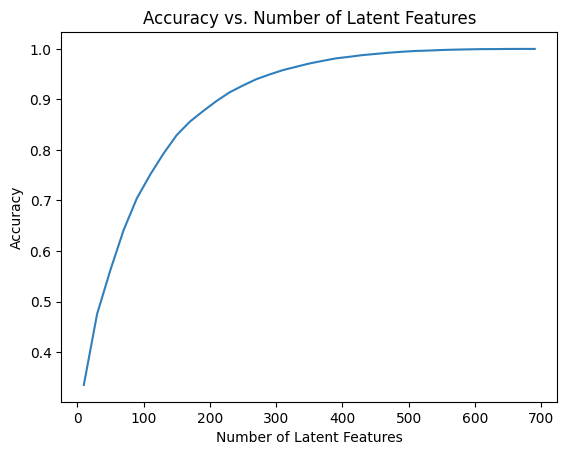

In [93]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Compute the dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Calculate total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0],color= "#2F7FBC");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [94]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
        df_train - training dataframe
        df_test - test dataframe
    
    OUTPUT:
        user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
        user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
        test_idx - all of the test user ids
        test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [95]:
# Common users:
train_idx = user_item_train.index
common_idx = np.intersect1d(train_idx, test_idx, assume_unique=True)

# Common articles:
train_arts = user_item_train.columns
common_arts = np.intersect1d(test_arts, train_arts, assume_unique=True)

# Print stats:
print(f"shape of user_item_train: {user_item_train.shape}")
print(f"shape of user_item_test: {user_item_test.shape}")
print(f"Nb common users in train and test sets: {len(common_idx)}")
print(f"Nb common articles in train and test sets: {len(common_arts)}\n")

print(f"a. Nb users in the test set we are not able to make predictions: {user_item_test.shape[0]-len(common_idx)}")
print(f"b. Nb articles we can make predictions for in the test set: {len(common_arts)}")
print(f"c. Nb users we can make predictions for in the test set: {len(common_idx)}")
print(f"d. Nb articles we are not able to make predictions for in the test set: {user_item_test.shape[1]-len(common_arts)}")

shape of user_item_train: (4487, 714)
shape of user_item_test: (682, 574)
Nb common users in train and test sets: 20
Nb common articles in train and test sets: 574

a. Nb users in the test set we are not able to make predictions: 662
b. Nb articles we can make predictions for in the test set: 574
c. Nb users we can make predictions for in the test set: 20
d. Nb articles we are not able to make predictions for in the test set: 0


In [97]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?':c , # letter here
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here
    'How many articles can we make predictions for in the test set?': b, # letter here
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [98]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

print('shape of u_train: ' , u_train.shape)
print('shape of s_train: ', s_train.shape)
print('shape of vt_train: ', vt_train.shape)

shape of u_train:  (4487, 4487)
shape of s_train:  (714,)
shape of vt_train:  (714, 714)


In [99]:
# Subset of rows and columns that match the test set
u_test = u_train[user_item_train.index.isin(test_idx),:]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

print('shape of u_test: ' , u_test.shape)
print('shape of vt_test: ', vt_test.shape)

shape of u_test:  (20, 4487)
shape of vt_test:  (714, 574)


In [100]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# Subset of user_item_test using common_idx (intersection of train_idx and test_idx):
user_item_test_subset = user_item_test.loc[common_idx]

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    
    # 1. Restructure with k latent features
    s_train_new = np.diag(s_train[:k])
    u_train_new = u_train[:, :k]
    vt_train_new = vt_train[:k, :]
    
    u_test_new = u_test[:, :k]
    vt_test_new = vt_test[:k, :]
    
    # 2. Make predictions using the dot product:
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # 3. Calculate the error of each prediction
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_preds)
    
    # 4. Calculate total errors - train
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    train_err = train_err/(user_item_train.shape[0]*user_item_train.shape[1])
    train_sum_errs.append(train_err)
    
    # 5. Calculate total errors - test
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    test_err = test_err/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])
    test_sum_errs.append(test_err)

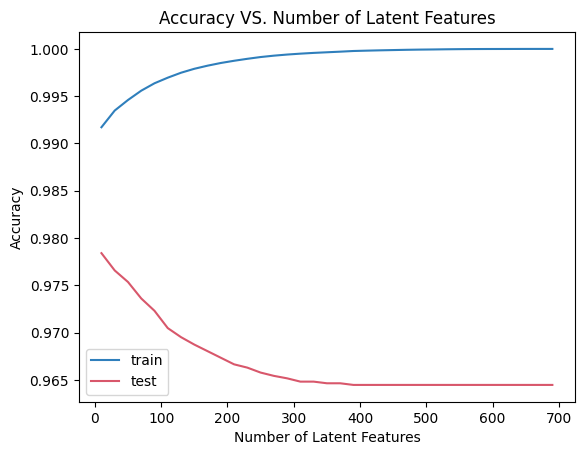

In [101]:
# Plot Accuracy VS. Number of Latent Features

plt.plot(num_latent_feats, 1 - (np.array(train_sum_errs)), label='train',color= "#2F7FBC");
plt.plot(num_latent_feats, 1 - (np.array(test_sum_errs)), label='test',color="#d8576b");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy VS. Number of Latent Features')
plt.legend(loc='best');

### Make recommendations with SVD

In [102]:
# Increasing the number of latent features causes overfitting during training. 
# Let's keep 100 latent features.

# Restructure with 100 latent features
num_latent_features = 100
vt_new = vt[:num_latent_features, :] 

In [105]:
def make_svd_recs(user_id, m , vt_new): 
    '''
    INPUT:
        user_id (int): user ID
        m (int): number of recommendations to return 
        vt_new: the restructured SVD vt matrix with k latent features (k=100)
    
    OUTPUT:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended  
    '''
    
    # 1. Get past article ids read by user_id
    article_ids = list(map(float, get_user_articles(user_id)[0]))
    
    # we will create a similarity DataFrame for each article_id
    # all_similarity_df will concatenate all these dataframes
    all_similarity_df = pd.DataFrame(columns=['article_id','similar_article_id','similarity'])
    
    v_new = vt_new.T # transpose vt_new so that articles are in rows
    
    # calculate magnitude before the for loop
    # Reference: https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/
    magnitude = np.sqrt(np.einsum('ij, ij -> i', v_new, v_new))

    for article_id in article_ids:
        try :
            # 1. Find article index in user_item matrix
            article_index = np.where(user_item.columns==article_id)[0][0]
            article_row = v_new[article_index, :]
            
            # 2. calculate cosine_similarity
            # magnitude = np.sqrt(np.einsum('ij, ij -> i', v_new, v_new))
            similarity = np.dot(article_row, vt_new) / (magnitude[article_index] * magnitude)

            # 3. Create dataframe containing: article_id,similar_article_id and similarity
            sim_df = pd.DataFrame(similarity,columns=['similarity']).reset_index()
            sim_df = sim_df.rename(columns={"index": "similar_article_index"})
            sim_df['similar_article_id'] = sim_df['similar_article_index'].apply(lambda index_:user_item.columns[index_])
            sim_df['article_index'] = article_index
            sim_df['article_id'] = user_item.columns[article_index]
            sim_df = sim_df[['article_id','similar_article_id','similarity']]
            sim_df = sim_df[sim_df.similar_article_id != sim_df.article_id]

            # 4. concat with all_similarity_df
            all_similarity_df = pd.concat([all_similarity_df,sim_df])

        except:
            pass

    # 5. sort by cosine similarity
    all_similarity_df = all_similarity_df.sort_values(by="similarity",ascending=False)

    # 6. exclude already read articles
    all_similarity_df = all_similarity_df[~all_similarity_df.similar_article_id.isin(article_ids)]

    recs = all_similarity_df.head(12)['similar_article_id'].to_list()

    rec_names = get_article_names(recs,df) 
    
    return recs, rec_names

Let's compare SVD to content-based and user-user based recs

In [106]:
user_id_ = ['25'] # you can change user_id

# 1. Get past articles read by the user
user_id = list(map(float, user_id_))[0] 
user_article_ids = list(map(float, get_user_articles(user_id)[0]))
user_article_names = get_article_names(user_article_ids)

print(f"* User {user_id} has already read\n",user_article_names)


# 2. Make SVD recommendations
print(f"\n* Make SVD based recommendations for user {user_id}")
try:
    recs,rec_names = make_svd_recs(user_id, 10 , vt_new)
    print('IDs:',recs,"\n")
    print('Names:',rec_names,"\n")
except:
    print(f"Article {article_id_} does not exist in df_content!")

    
# 3. Make a content_based recommendations
print(f"\n* Make content based recommendations for user {user_id}")

try:
    recs,rec_names = make_content_recs(user_id_, _id_type='user')
    print('IDs:',recs,"\n")
    print('Names:',rec_names,"\n")
except:
    print(f"Article {article_id_} does not exist in df_content!")
    
    
# 4. Make User-User Based Collaborative Filtering recommendations:
print(f"\n* Make User-User based recommendations for user {user_id}")
try:
    recs,rec_names = user_user_recs_part2(20, 10)
    print('IDs:',recs,"\n")
    print('Names:',rec_names,"\n")
except:
    print(f"Article {article_id_} does not exist in df_content!")

* User 25.0 has already read
 ['analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings']

* Make SVD based recommendations for user 25.0
IDs: [480.0, 1157.0, 1063.0, 1074.0, 1188.0, 865.0, 967.0, 1190.0, 1122.0, 1441.0, 928.0, 92.0] 

Names: ['optimization for deep learning highlights in 2017', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: antwerp listings', 'airbnb data for analytics: barcelona reviews', 'consumption of ozone-depleting cfcs in odp metric tons', 'analyze traffic data from the city of san francisco', 'ml algorithm != learning machine', 'country population by gender 1985-2005', 'airbnb data for analytics: paris reviews', 'world tourism data by the world tourism organization', 'time series anomaly detection algorithms – stats and bots', '9 mistakes to avoid when starting your career in data science'] 


* Make content based recommendations for user 25.0
IDs: [1330. 1161. 1208. 1306. 1318. 1283. 1165. 12

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

> 📖 **Answser:**
> As the number of latent features increases, the training accuracy of the model increases while the test accuracy decreases.<br>
> ```Increasing the number of latent features causes overfitting during training. We should keep fewer latent features (betwwen 100 and 200).```<br><br>
> 🔑 To ensure **diversity**, We can build a recommendation system using an ensemble of all algorithms (top ranked, content-based, ...)
> 1. For new users, we simply return the top ranked articles.<br>
> 2. For other users, we return three lists as follows:
>     - Recommendations based on **SVD**. We call this list `Recommended for you`
>     - **Content based** list. For example, we can use NLP to return articles that are similar to the last read article. We call this list `Because you read`br>.
>     - **User-user** based recs. We call this list `Users are viewing`
> 3. **knowledge based** recs: returns a list of filtered and top ranked articles.  

> 🔑 To **improve our RecSys**, we can use rating metrics so that we know exactly whether the user who clicked on the article liked it or not. <br><br>
> Most importantly, an **A/B test** is the best way to test how well our RecSys works in practice.<br>
> SVD, for example, is more than 96% accurate. But do users like our recommendations?

<a id='FlaskApp'></a>
### Flask App 

**Github Link:** <a style="font-size: large;" href="https://github.com/AlaGrine/udacity-recommendations-with-IBM" target="_blank"> https://github.com/AlaGrine/udacity-recommendations-with-IBM </a>


A responsive **Flask** WEB app is developped to display our recommendation results.

Below are a few screenshots of the web app. But before displaying the screenshots, let's create a function for embedding images and exporting to html.

In [107]:
#Reference: https://stackoverflow.com/questions/51975699/embedding-image-into-jupyter-notebook-and-exporting-to-html

import base64, io, IPython
from PIL import Image as PILImage

def html_base64_image(image_path):
    '''converte image to Base64'''
    image = PILImage.open(image_path)

    output = io.BytesIO()
    image.save(output, format='PNG')
    encoded_string = base64.b64encode(output.getvalue()).decode()

    html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
    return html

**1. Rank based recs** - recommended articles for a new user.

You can create a new user via the `Sign up` page.

After `Login`, the RecSys returns the top `m` ranked articles (a `Bootstrap Carousel` is used for better navigation).


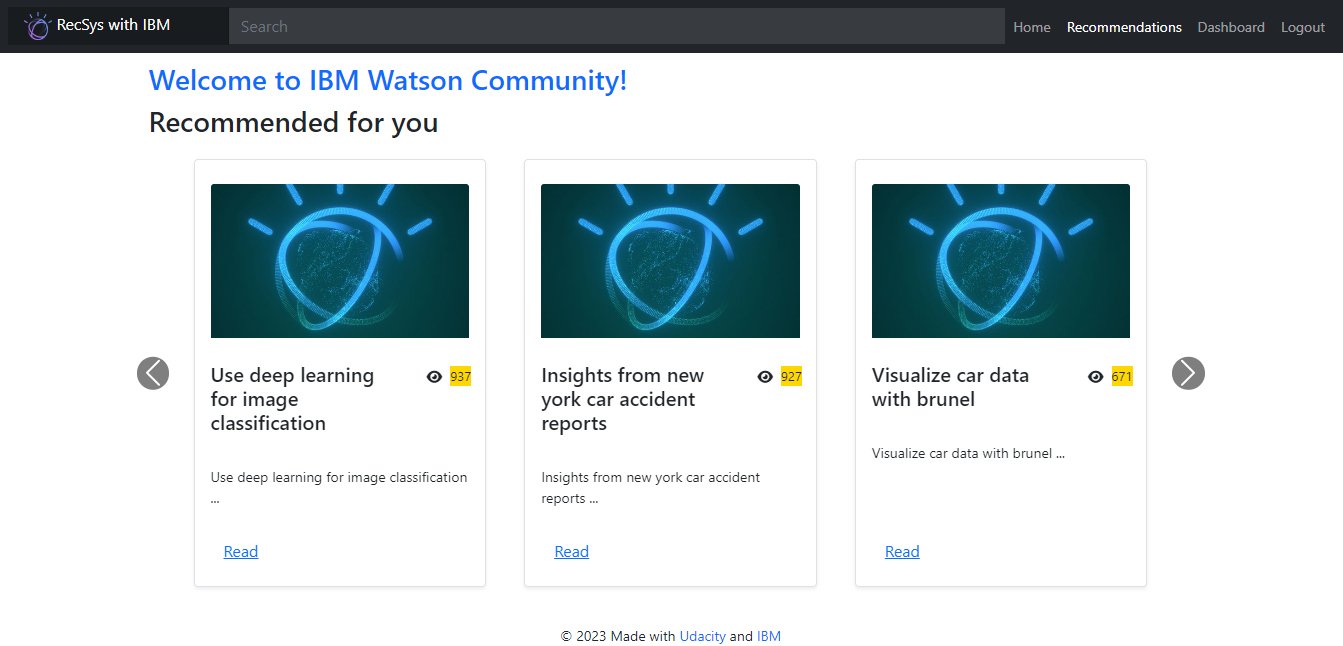

In [108]:
IPython.display.HTML(html_base64_image("./imgs/top_ranked.png"))

**2. Recs based on SVD**

When you read an article (for example '_Use deep learning for image classification_'), our RecSys generates three lists. <br><br>
The first list is based on **SVD**. This list is called `Recommended for you`.


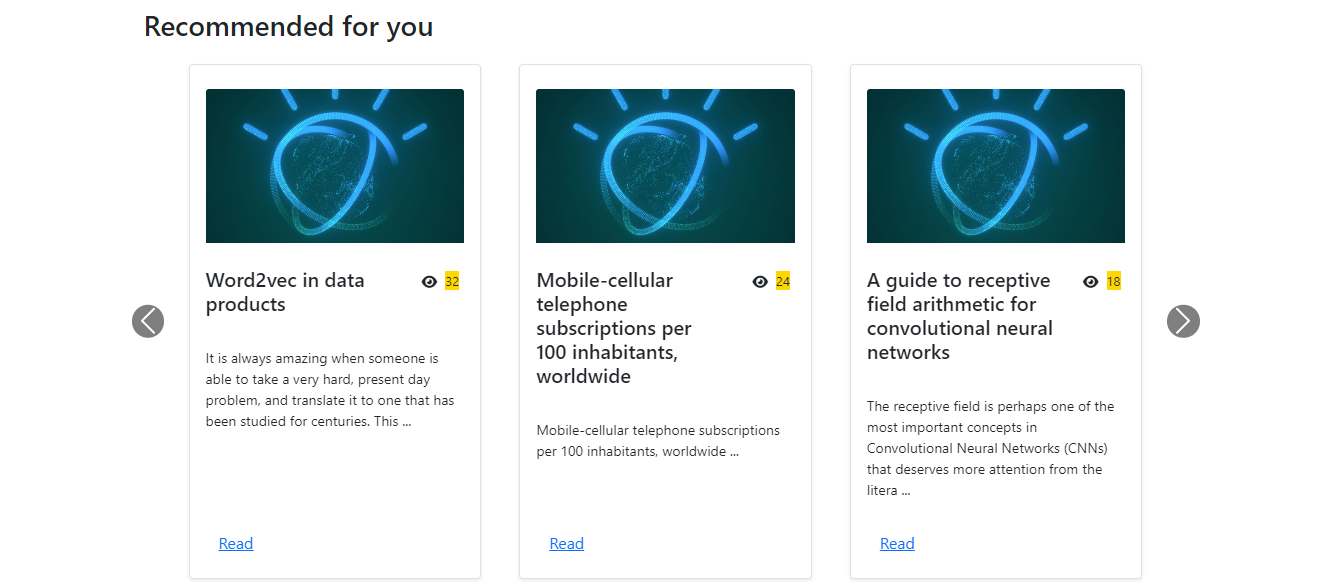

In [109]:
IPython.display.HTML(html_base64_image("./imgs/SVD_recs.png"))

**User-user based recs**

The second list is a user-user based recs. This list is called `Users are viewing`.


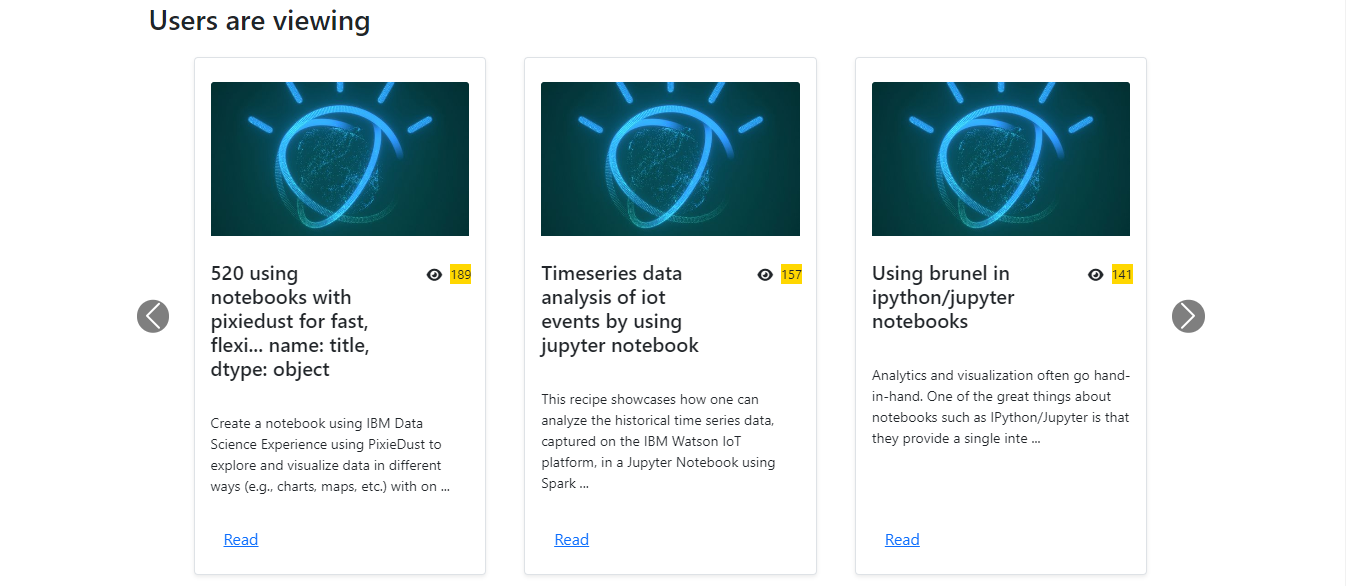

In [110]:
IPython.display.HTML(html_base64_image("./imgs/User_are_viewing.png"))

**Content based recs**

The third list is the output of the content based algorithm. This list is called `Because you have read`


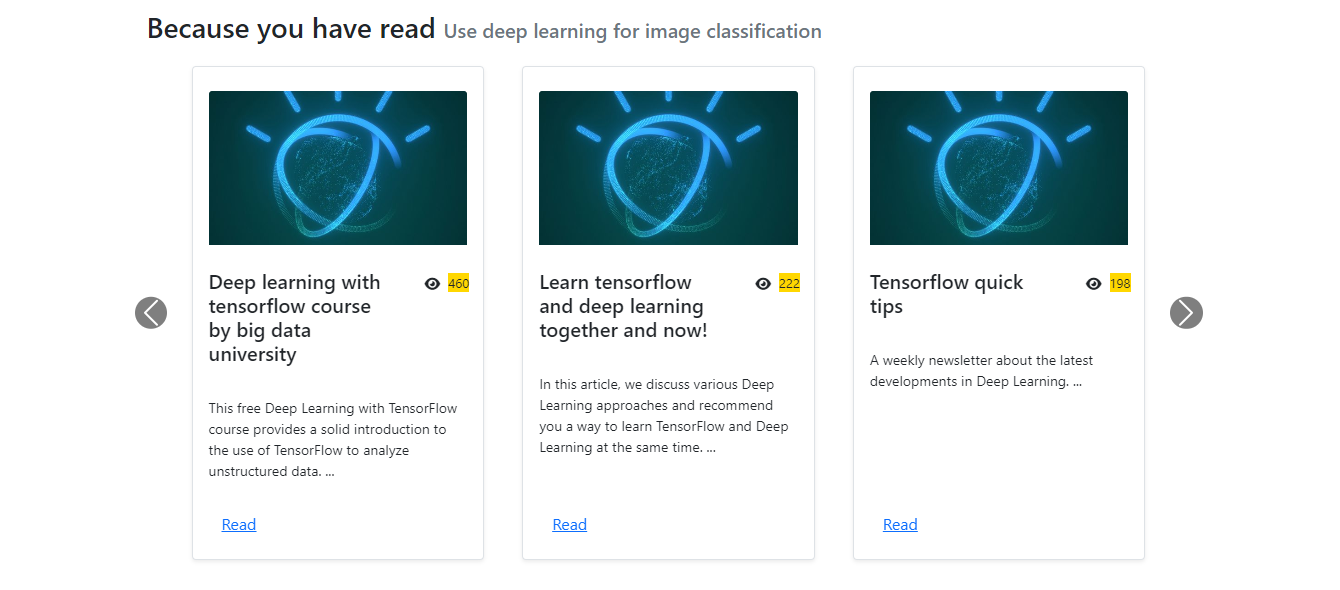

In [111]:
IPython.display.HTML(html_base64_image("./imgs/Content_recs.png"))

**Knowledge based recs** (Top ranked + filter)

You can apply a filter (using the _search TextArea_). The output is a list of filtered and top ranked articles.


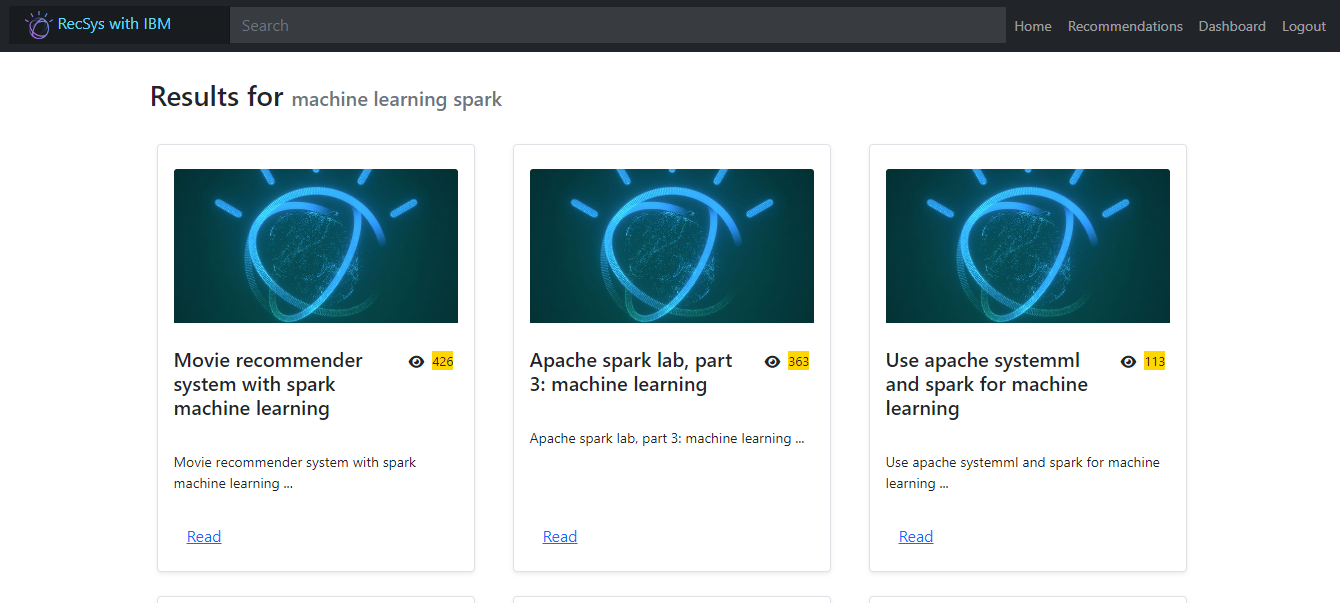

In [112]:
IPython.display.HTML(html_base64_image("./imgs/Knowledge_recs.png"))

<a id='conclusions'></a>

## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [71]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])